# Модель шумности аэродинамического профиля

Исходные данные:

1. Частота, Гц.
2. Угол атаки, град.
3. Длина хорды аэродинамического профиля, м.
4. Скорость набегающего потока, м/с.
5. Толщина аэродинамического профиля, м.

Результирующие данные:

6. Масштабированный уровень звукового давления, Дб.

## Импорт библиотек

In [1]:
import sys
import numpy as np
from copy import deepcopy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from colorama import Fore

from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler, QuantileTransformer, PowerTransformer

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, Lars, LassoLars, OrthogonalMatchingPursuit, BayesianRidge, ARDRegression, SGDRegressor, RANSACRegressor, GammaRegressor, PoissonRegressor, HuberRegressor, TweedieRegressor, LogisticRegression, QuantileRegressor, TheilSenRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, BaggingRegressor, AdaBoostRegressor, HistGradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, max_error
from sklearn.metrics import explained_variance_score, r2_score

In [2]:
sys.path.append('D:/Programming/Python')

In [3]:
from tools import export2, rounding
from decorators import timeit

## Определение констант

In [4]:
SCALERS = (StandardScaler(), MinMaxScaler(), MaxAbsScaler(), RobustScaler(), QuantileTransformer(), PowerTransformer())

MODELS = [LinearRegression(), ElasticNet(),  Ridge(), Lasso(), Lars(), LassoLars(), OrthogonalMatchingPursuit(), BayesianRidge(), ARDRegression(), SGDRegressor()]
MODELS += [RandomForestRegressor(), ExtraTreesRegressor(), GradientBoostingRegressor(), BaggingRegressor(), AdaBoostRegressor(), HistGradientBoostingRegressor()]
MODELS += [DecisionTreeRegressor()]

## Импорт датасета

In [5]:
df = pd.read_csv("airfoil_self_noise.dat", sep="\t", header=None)
df

,0,1,2,3,4,5
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461
...,...,...,...,...,...,...
1498,2500,15.6,0.1016,39.6,0.052849,110.264
1499,3150,15.6,0.1016,39.6,0.052849,109.254
1500,4000,15.6,0.1016,39.6,0.052849,106.604
1501,5000,15.6,0.1016,39.6,0.052849,106.224


## Обработка данных

In [6]:
df.columns = ["Frequency [Hz]", "Attack angle [deg]", "Chord length [m]", "Free-stream velocity [m/s]", "Thickness [m]", "Pressure level [db]"]

In [7]:
df

,Frequency [Hz],Attack angle [deg],Chord length [m],Free-stream velocity [m/s],Thickness [m],Pressure level [db]
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461
...,...,...,...,...,...,...
1498,2500,15.6,0.1016,39.6,0.052849,110.264
1499,3150,15.6,0.1016,39.6,0.052849,109.254
1500,4000,15.6,0.1016,39.6,0.052849,106.604
1501,5000,15.6,0.1016,39.6,0.052849,106.224


Проверка однотипности данных и локальных пустот

In [8]:
df.isnull().sum()

Frequency [Hz]                0
Attack angle [deg]            0
Chord length [m]              0
Free-stream velocity [m/s]    0
Thickness [m]                 0
Pressure level [db]           0
dtype: int64

Разделение данных на признаки и целевую функцию

In [9]:
x_df, y_df = df.iloc[:,:-1], df.iloc[:,-1]
pd.concat([x_df, y_df], axis=1)

,Frequency [Hz],Attack angle [deg],Chord length [m],Free-stream velocity [m/s],Thickness [m],Pressure level [db]
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461
...,...,...,...,...,...,...
1498,2500,15.6,0.1016,39.6,0.052849,110.264
1499,3150,15.6,0.1016,39.6,0.052849,109.254
1500,4000,15.6,0.1016,39.6,0.052849,106.604
1501,5000,15.6,0.1016,39.6,0.052849,106.224


In [10]:
class DataML:
    def __init__(self, data, scaler=None):
        assert type(data) is np.ndarray, 'type(data) is numpy.ndaray!'
        self.data = data if len(data.shape) > 1 else data.reshape(-1, 1)
        self.scaler = scaler
        self.scaled = data
        self.train = data
        self.test = data

    def __str__(self):
        return type(self).__name__

    def fit(self):
        if not self.scaler: return self.scaler
        return self.scaler.fit(self.data)

    def transform(self):
        if not self.scaler: 
            self.scaled = self.data
        else:
            self.scaled = self.scaler.transform(self.data)
        return self.scaled
    
    def inverse_transform(self):
        if not self.scaler: 
            self.data = self.scaled
        else:
            self.data = self.scaler.inverse_transform(self.scaled)
        return self.data
    
    def fit_transform(self):
        self.fit()
        return self.transform()

In [11]:
xs = [DataML(x_df.to_numpy(), scaler=None)]
ys = [DataML(y_df.to_numpy(), scaler=None)]
for scaler in SCALERS:
    xs.append(DataML(x_df.to_numpy(), scaler=deepcopy(scaler)))
    ys.append(DataML(y_df.to_numpy(), scaler=deepcopy(scaler)))

Нормализация

In [12]:
for x, y in zip(xs, ys):
    x.fit_transform()
    y.fit_transform()

Разделение данных для обучения и тестирования

In [13]:
test_size = 0.2 # процентное соотношение тестированных данных ко всем данным 
shuffle = True
random_state = 0 # семя рандома

In [14]:
for x, y in zip(xs, ys):
    x.train, x.test, y.train, y.test = train_test_split(x.scaled, y.scaled, test_size=test_size, 
                                                        shuffle=shuffle, random_state=random_state)

## Визуализация обработки данных 

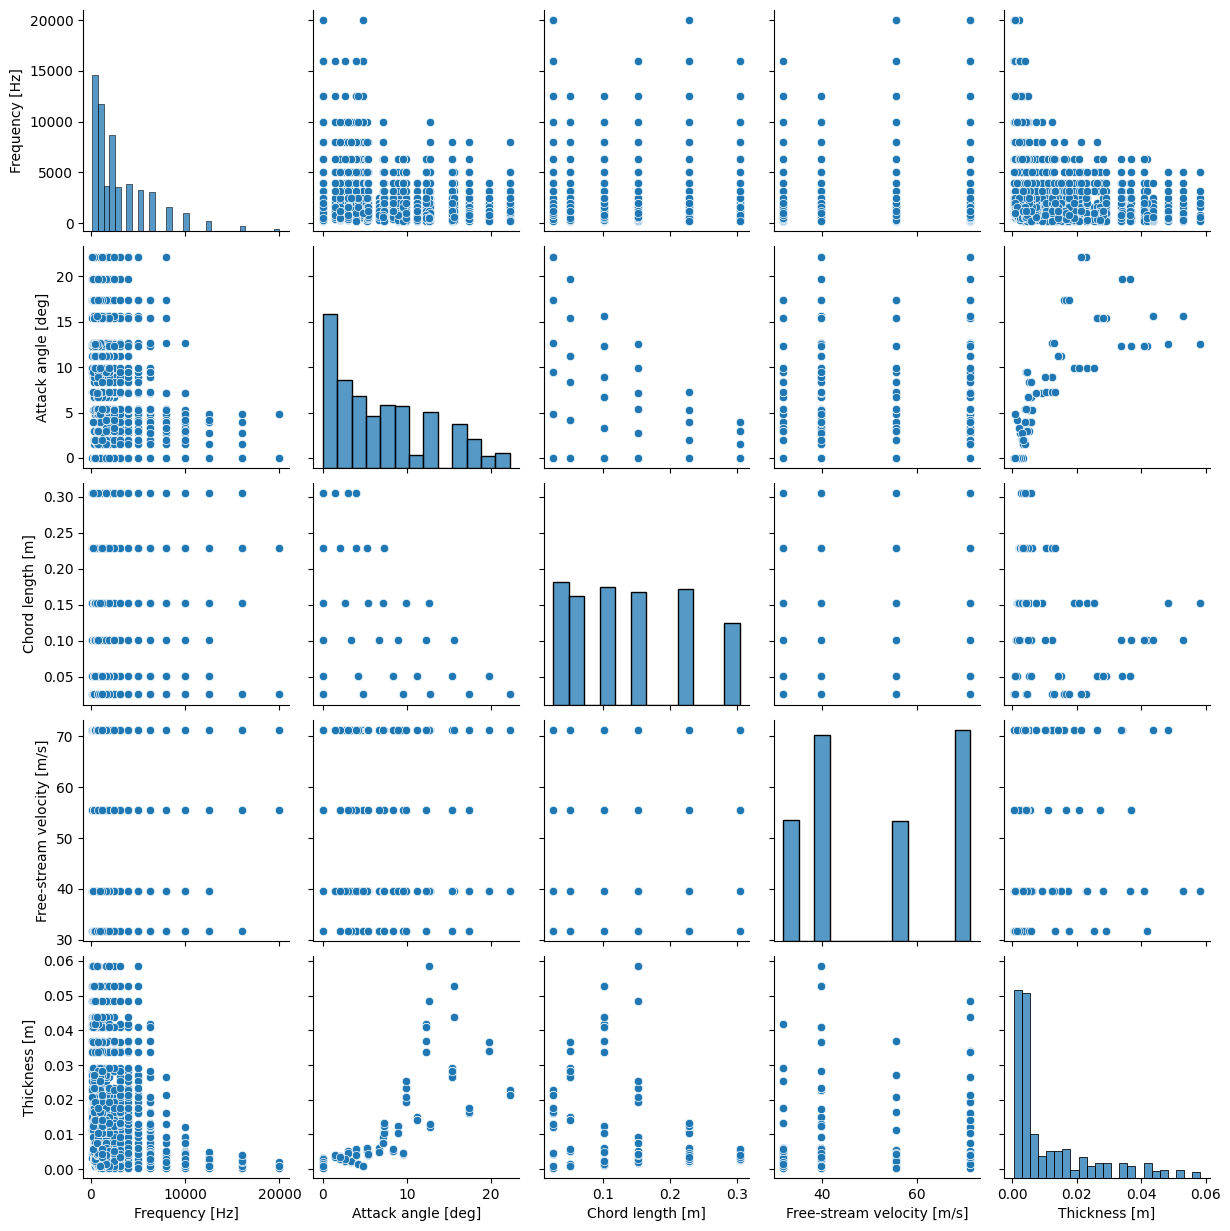

In [15]:
sns.pairplot(pd.DataFrame(xs[0].train, columns=df.columns[:-1]));

## Обучение модели регрессии

In [16]:
class Model:
    def __init__(self, model):
        self.model = model

    def __str__(self):
        return f'{type(self.model).__name__}(x.scaler={self.x.scaler}, y.scaler={self.y.scaler})'
    
    def __call__(self):
        return self.model

    def fit(self, x, y):
        self.model.fit(x, y.reshape(-1,))

    def predict(self, x):
        return self.model.predict(x)
    
    def prediction(self, action: str, y_true, y_possible, suptitle='Prediction', bins=40):

        fg = plt.figure(figsize=(12, 8))  # размер в дюймах 
        plt.suptitle(suptitle, fontsize=14, fontweight = 'bold')
        gs = fg.add_gridspec(1, 2)
        
        fg.add_subplot(gs[0, 0])  # позиция графика
        plt.grid(True)  # сетка
        plt.hist(y_true - y_possible, bins=bins)

        fg.add_subplot(gs[0, 1])  # позиция графика
        plt.grid(True)  # сетка
        plt.scatter(y_true, y_possible, c='red')
        plt.plot(y_true, y_true, color='blue')    
        
        if action == 'export': export2(plt, file_name=suptitle, file_extension='png')

    def transform_predict(self, data):
            x = DataML(data, scaler=self.x.scaler)
            x.transform()
            prediction_scaled = self.model.predict(x.scaled)
            y = DataML(prediction_scaled, scaler=self.y.scaler)
            y.scaled = prediction_scaled
            return y.inverse_transform()

    def contain(self):
        obj = Model(deepcopy(self.model))
        return obj

In [17]:
scoring = 'neg_mean_squared_error'
cv = 5  # cross validation score
parameters = {'alpha':[1e-15, 1e-10, 1e-8, 1e-3, 1e-2, 1, 5, 10, 20, 30, 35, 40, 45, 50, 55, 100]}

In [18]:
'''models = dict()
for model in MODELS:
    model_name = type(model).__name__
    print(Fore.MAGENTA + model_name + Fore.RESET)
    models[model_name] = dict()
    for scaler_name in datas.keys():
        print('\t' + Fore.CYAN + scaler_name + Fore.RESET)
        models[model_name][scaler_name] = {'model': deepcopy(model), 'scaler': datas[scaler_name]['scaler']}
        mse = cross_val_score(models[model_name][scaler_name]['model'], 
                              datas[scaler_name]['x_train'], 
                              datas[scaler_name]['y_train'], 
                              scoring=scoring, cv=cv)
        mean_mse=np.mean(mse)
        print('\t\t' + f'mean_mse={mean_mse}')'''
'''for regressor in (Ridge(), Lasso()):
    print(type(regressor).__name__)
    regressors.append(regressor)
    gscv = GridSearchCV(regressor, parameters, scoring=scoring, cv=cv)
    gscv.fit(x_train, y_train)
    print(gscv.best_score_)'''

'for regressor in (Ridge(), Lasso()):\n    print(type(regressor).__name__)\n    regressors.append(regressor)\n    gscv = GridSearchCV(regressor, parameters, scoring=scoring, cv=cv)\n    gscv.fit(x_train, y_train)\n    print(gscv.best_score_)'

In [19]:
models = list()
for x in xs:
    for y in ys:
        for model in MODELS:
            print('\r' + f'model: {type(model).__name__} x.csaler: {x.scaler} y.scaler: {y.scaler}', end='')
            models.append(Model(deepcopy(model)))
            models[-1].x = x
            models[-1].y = y
            models[-1].fit(x.train, y.train)
            print('\r' + ' ' * 100, end='')
print('\r' + f'len(models) = {len(models)}')

len(models) = 833                                                                                   


## Тестирование

In [20]:
for model in models:
    model.predictions_train = model.predict(model.x.train)
    model.predictions_test = model.predict(model.x.test)

In [21]:
def err(y_true, y_possible) -> dict[str: float]:
    """Погрешность"""
    dct = dict()
    dct[mean_absolute_error.__name__] = mean_absolute_error(y_true, y_possible)
    dct[mean_squared_error.__name__] = mean_squared_error(y_true, y_possible)
    dct[max_error.__name__] = max_error(y_true, y_possible)
    return dct

In [22]:
def scr(y_true, y_possible) -> dict[str: float]:
    """Счет"""
    dct = dict()
    dct[explained_variance_score.__name__] = explained_variance_score(y_true, y_possible)
    dct[r2_score.__name__] = r2_score(y_true, y_possible)
    return dct

In [23]:
print('test\n\n')
for model in models:
    print(Fore.MAGENTA + str(model) + Fore.RESET)
    model.score_test = model.model.score(model.x.test,model.y.test)
    for k, v in scr(model.y.test, model.model.predict(model.x.test)).items():
        print('\t' + f'{k}: {v}')
    for k, v in err(model.y.test, model.model.predict(model.x.test)).items():
        print('\t' + f'{k}: {v}')
    print()

test


LinearRegression(x.scaler=None, y.scaler=None)
	explained_variance_score: 0.5585711249865444
	r2_score: 0.558555727310099
	mean_absolute_error: 3.545248297264676
	mean_squared_error: 20.765101495623508
	max_error: 15.344561564626659

ElasticNet(x.scaler=None, y.scaler=None)
	explained_variance_score: 0.3182240794332123
	r2_score: 0.31787271862722566
	mean_absolute_error: 4.454955182895812
	mean_squared_error: 32.08659191414952
	max_error: 16.81811168247323

Ridge(x.scaler=None, y.scaler=None)
	explained_variance_score: 0.5255055890207465
	r2_score: 0.5255046588533734
	mean_absolute_error: 3.6915676828106796
	mean_squared_error: 22.31979103063717
	max_error: 14.958277675042822

Lasso(x.scaler=None, y.scaler=None)
	explained_variance_score: 0.3161350311863461
	r2_score: 0.31579512233275175
	mean_absolute_error: 4.455010176051646
	mean_squared_error: 32.18431998673002
	max_error: 16.82337919466231

Lars(x.scaler=None, y.scaler=None)
	explained_variance_score: 0.5585711249865439
	r2

## Выбор модели регрессии

Сортировка моделей по убыванию значения score_test

In [24]:
models = sorted(models, key=lambda model: model.score_test, reverse=True)
for model in models:
    print(f'{model} score [%]: {model.score_test * 100}')

ExtraTreesRegressor(x.scaler=RobustScaler(), y.scaler=MinMaxScaler()) score [%]: 95.37703552188918
ExtraTreesRegressor(x.scaler=StandardScaler(), y.scaler=MinMaxScaler()) score [%]: 95.19621629274715
ExtraTreesRegressor(x.scaler=MaxAbsScaler(), y.scaler=StandardScaler()) score [%]: 95.1685386250482
ExtraTreesRegressor(x.scaler=None, y.scaler=None) score [%]: 95.1426605880204
ExtraTreesRegressor(x.scaler=StandardScaler(), y.scaler=RobustScaler()) score [%]: 95.12300964677488
ExtraTreesRegressor(x.scaler=MaxAbsScaler(), y.scaler=RobustScaler()) score [%]: 95.11691156815769
ExtraTreesRegressor(x.scaler=MinMaxScaler(), y.scaler=MinMaxScaler()) score [%]: 95.10457036736265
ExtraTreesRegressor(x.scaler=None, y.scaler=MaxAbsScaler()) score [%]: 95.08486730465034
ExtraTreesRegressor(x.scaler=None, y.scaler=StandardScaler()) score [%]: 95.07847551120875
ExtraTreesRegressor(x.scaler=None, y.scaler=RobustScaler()) score [%]: 95.05481443409457
ExtraTreesRegressor(x.scaler=None, y.scaler=MinMaxScal

In [25]:
best_model = models[0]

print(f'best model: {str(best_model)}')
print(f'score: {best_model.score_test}')
best_model = models[4]

best model: ExtraTreesRegressor(x.scaler=RobustScaler(), y.scaler=MinMaxScaler())
score: 0.9537703552188919


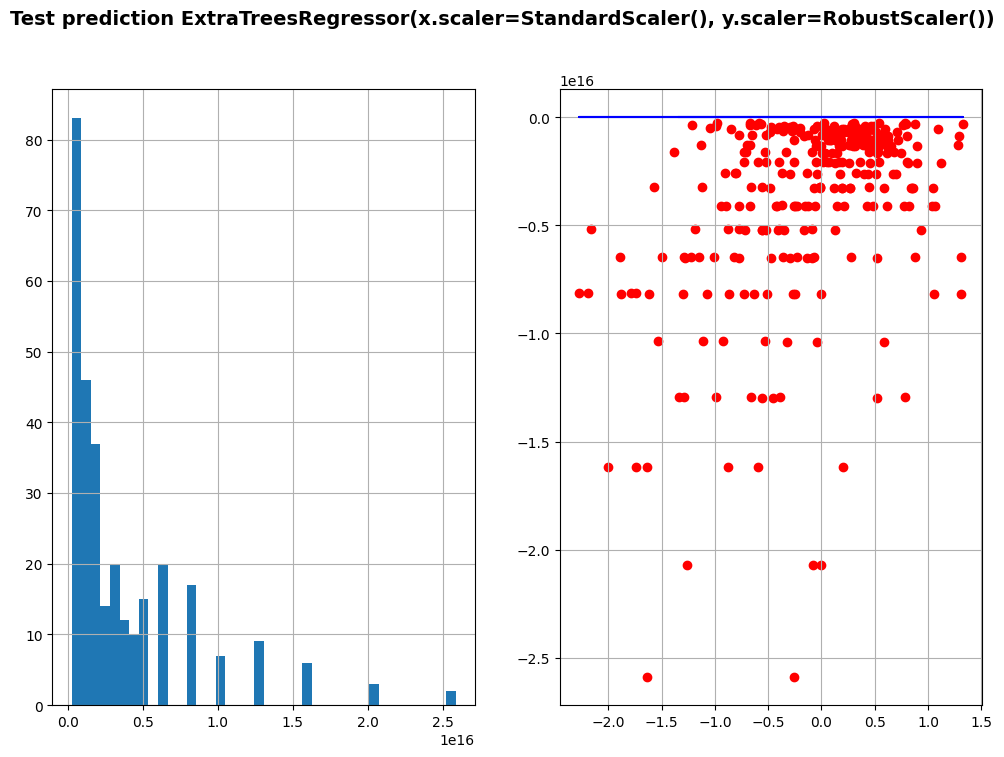

In [26]:
best_model.prediction('show', best_model.y.test.reshape(-1,), model.predictions_test, 
                 suptitle= 'Test prediction ' + f'{type(best_model.model).__name__}(x.scaler={best_model.x.scaler}, y.scaler={best_model.y.scaler})');

In [27]:
for model in models:
    if not model.x.scaler and not model.y.scaler:
        best_model = model
        break

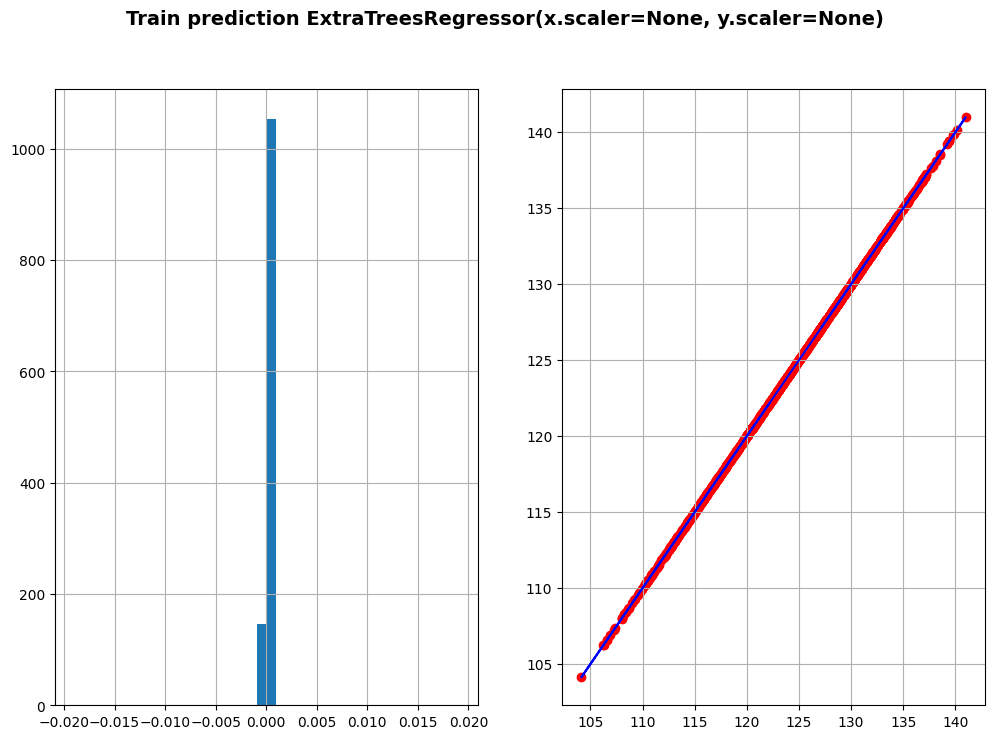

In [28]:
best_model.prediction('show', best_model.y.train.reshape(-1,), model.predictions_train, 
                 suptitle= 'Train prediction ' + f'{type(best_model.model).__name__}(x.scaler={best_model.x.scaler}, y.scaler={best_model.y.scaler})')

"d:\Study\ГТДиГТУ\GTE\Расчеты\airfoil_noise/exports/Test prediction ExtraTreesRegressor(x.scaler=None, y.scaler=None).png" file has created!
"export2" elapsed 0.466 seconds


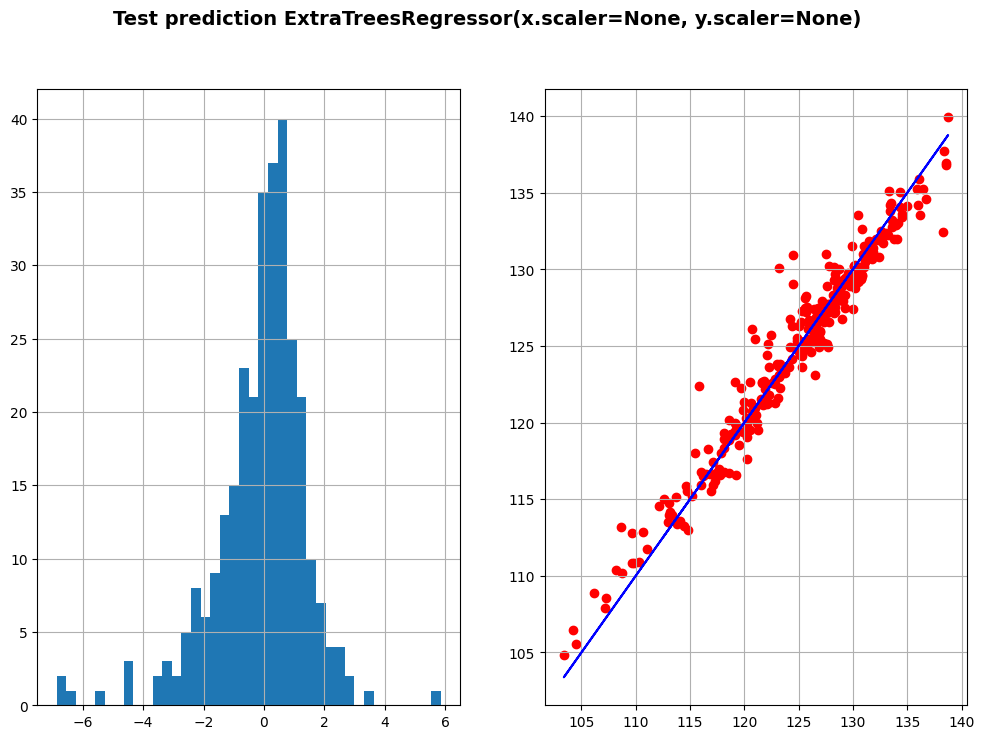

In [29]:
best_model.prediction('export', best_model.y.test.reshape(-1,), model.predictions_test, 
                 suptitle= 'Test prediction ' + f'{type(best_model.model).__name__}(x.scaler={best_model.x.scaler}, y.scaler={best_model.y.scaler})')

## Упаковка модели

In [30]:
#model = best_model.contain()
model = best_model

## Экспорт модели 

In [31]:
pickle.dump(model, open('model.pkl', 'wb'))

## Импорт модели

In [32]:
model = pickle.load(open('model.pkl', 'rb'))

## Автоматическое тестирование

In [33]:
model.model.score(best_model.x.test, 
                  best_model.y.test)

0.9514266058802041

## Ручное тестирование

In [34]:
df

,Frequency [Hz],Attack angle [deg],Chord length [m],Free-stream velocity [m/s],Thickness [m],Pressure level [db]
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461
...,...,...,...,...,...,...
1498,2500,15.6,0.1016,39.6,0.052849,110.264
1499,3150,15.6,0.1016,39.6,0.052849,109.254
1500,4000,15.6,0.1016,39.6,0.052849,106.604
1501,5000,15.6,0.1016,39.6,0.052849,106.224


In [35]:
airfoil_props = {"Frequency [Hz]": [800], 
                 "Attack angle [deg]": [0], 
                 "Chord length [m]" : [0.3048], 
                 "Free-stream velocity [m/s]": [71.3], 
                 "Thickness [m]": [0.002663]}
airfoil_props = pd.DataFrame(airfoil_props)
airfoil_props

,Frequency [Hz],Attack angle [deg],Chord length [m],Free-stream velocity [m/s],Thickness [m]
0,800,0,0.3048,71.3,0.002663


In [36]:
print(f'Pressure level: {model.transform_predict(airfoil_props.to_numpy())[0].round(4)} [db]')

Pressure level: 126.201 [db]
